# Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import json
# used to inject progress bar into pandas apply function
from tqdm.notebook import tqdm
tqdm.pandas()

claim_path = "../dataset/out_claim.zip"
title_path = "../dataset/out_title.zip"
description_path = "../dataset/out_descr.zip"

We will first load all the data into the dataframe `df` by joining all the different dataframes (claims, titles, descriptions) into a unique dataframe.

In [2]:
df = pd.read_csv(claim_path, compression="zip") \
         .drop(columns=["Unnamed: 0", "Language", "PatenType", "PublicationType", "Language", "Part", "Number"]) \
         .rename(columns={"Contents": "claims"}).rename(str.lower, axis="columns") \
         .set_index("patentnumber")

In [3]:
title = pd.read_csv(title_path, compression="zip") \
          .drop(columns=["Unnamed: 0", "Language", "PatenType", "PublicationType", "Language", "Part", "Number", "Date"]) \
          .rename(columns={"Contents": "title"}).rename(str.lower, axis="columns") \
          .set_index("patentnumber")

df = df.join(title)
del title

In [4]:
desc = pd.read_csv(description_path, compression="zip") \
          .drop(columns=["Unnamed: 0", "Language", "PatenType", "PublicationType", "Language", "Part", "Number", "Date"]) \
          .rename(columns={"Contents": "description"}).rename(str.lower, axis="columns") \
          .set_index("patentnumber")

df = df.join(desc)
del desc

In [5]:
df.head()

,date,claims,title,description
patentnumber,,,,
3000006,2018-02-28,['A complementary metal oxide semiconductor vo...,"ALL-CMOS, LOW-VOLTAGE, WIDE-TEMPERATURE RANGE,...","{'BACKGROUND OF THE INVENTION': [], 'FIELD OF ..."
3000007,2020-07-08,['A method for configuring a user interface of...,SYSTEM AND METHOD FOR OPTIMIZED APPLIANCE CONTROL,"{'BACKGROUND': ['Controlling devices, for exam..."
3000011,2017-05-03,['A method (400) of positioning one or more vi...,BODY-LOCKED PLACEMENT OF AUGMENTED REALITY OBJ...,{'BACKGROUND': ['An augmented reality computin...
3000012,2019-05-01,['A method of displaying a schedule in a weara...,METHOD AND APPARATUS FOR DISPLAYING SCHEDULE O...,{'Technical Field': ['The present disclosure r...
3000013,2020-05-06,['A remote controller adapted to interact with...,INTERACTIVE MULTI-TOUCH REMOTE CONTROL,{'BRIEF DESCRIPTION OF THE SEVERAL VIEWS OF TH...


## Summary extraction

Each patent is usually composed of several different sections each containing different information.
In order to generate the first indipendent claim not all the sections are needed.

In [6]:
# extract all the headings
headings = df["description"].progress_apply(
    lambda r: [k.lower() for k in eval(r).keys()],
    convert_dtype=False)

headings_set = set(headings.explode())
print(f"{len(headings_set)} different headings in the whole dataset.")

  0%|          | 0/43182 [00:00<?, ?it/s]

276701 different headings in the whole dataset.


We end up with $\geq 276000$ different headings.

In [7]:
from collections import Counter
counts = Counter(headings.explode().tolist())
top10_headings = sorted(dict(counts), key=counts.get, reverse=True)[:10]

for h in top10_headings:
  print(f"{h.ljust(35)} | {str(counts[h]).rjust(5)} times")


brief description of the drawings   | 22006 times
background                          | 15364 times
technical field                     | 13180 times
detailed description                | 12998 times
summary of the invention            | 12388 times
summary                             | 12098 times
background of the invention         |  9785 times
field of the invention              |  7953 times
background art                      |  6521 times
examples                            |  6305 times


Most of them are, as we could expect, repeated lots of time.
To obtain a corpus whose content is composed of meaningful descriptions of the patent we will extract those sections that constitutes a summary of the whole description. 

A simple way to accomplish it is to extract only those descriptions whose title contains the term *summary*.

In [8]:
df["summaries"] = df["description"].progress_apply(
    lambda r: [eval(r)[k] for k in eval(r).keys() if 'summary' in k.lower()],
    convert_dtype=False)

  0%|          | 0/43182 [00:00<?, ?it/s]

In [9]:
# filter out all the patents that contains more than one section named summary
df = df[df['summaries'].progress_apply(len) == 1]

  0%|          | 0/43182 [00:00<?, ?it/s]

In [10]:
print(f"{df.shape[0]} patents with one section containing the term summary")

30824 patents with one section containing the term summary


Indeed we end up with roughly $30000$ documents.

In [11]:
# summaries end up being a list of paragraphs, join all the paragraph in one
# big text corpora
df['summaries'] = df['summaries'].apply(lambda r: ' '.join(r[0]))
df = df.rename(columns={"summaries": "summary"})

In [12]:
# extract summary titles as well
df['summary_title'] = df["description"].progress_apply(
    lambda r: [k.lower() for k in eval(r).keys() if 'summary' in k.lower()][0],
    convert_dtype=False)

  0%|          | 0/30824 [00:00<?, ?it/s]

In [13]:
df[["summary", "summary_title"]]

,summary,summary_title
patentnumber,,
3000006,The present invention is a voltage reference. ...,brief summary of the invention
3000007,"According to the invention, a method according...",summary of the invention
3000011,Embodiments are disclosed that relate to posit...,summary
3000019,In a first aspect there is provided a method a...,brief summary
3000020,Embodiments of the present technology relate t...,summary
...,...,...
3099989,The present applicant has mitigated the above ...,summary of invention
3099990,The present invention is a distillation column...,summary of the invention
3099991,The present invention is set forth and charact...,summary of the invention


Extracting summaries in such a way, while based on an extremely simple heuristic, might add unwanted noise into the corpora. For instance if *summary of the results* is present, it would be used as the patent description.

Since we only have $\approx 250$ different titles we will annotate them manually by using a simple script ([annotate_summaries.py](./annotate_summaries.py)) that will output a JSON file containing the human made annotation.

In [4]:
with open("titles.json", "w") as fp:
  json.dump(df["title"].unique().tolist(), fp)

In [14]:
# load annotations
with open('annotated.json') as f:
    annotated = json.load(f)
    annotated = {k: int(v) for k, v in annotated.items() }

In [15]:
summary_title = next(filter(lambda x: annotated.get(x), annotated.keys()))
not_summary_title = next(filter(lambda x: not annotated.get(x), annotated.keys()))

print(f"*{summary_title}* is a proper summary")
print(f"*{not_summary_title}* is not a proper summary")

*summary of the described embodiments* is a proper summary
*brief summary of some examples* is not a proper summary


We can try to build a decision tree out of the annotated titles in order to better understand, from a natural language understanding point of view, how to effectively recognize summaries from other sections.

We will vectorize the text by relying on a simple bag of word method.

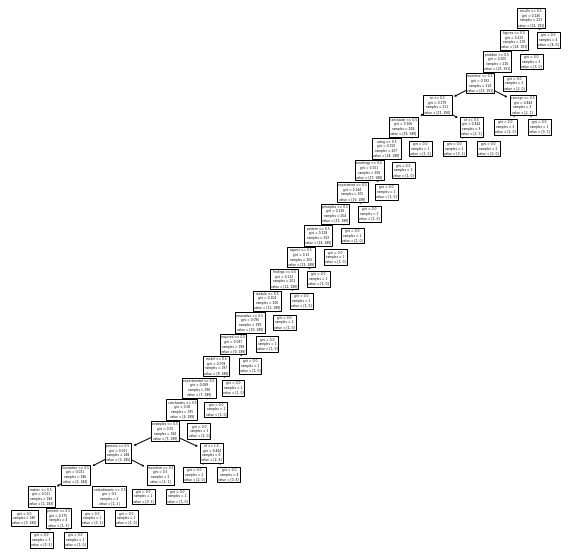

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree
import joblib
import matplotlib.pyplot as plt

count_vect = CountVectorizer()
X = count_vect.fit_transform(annotated.keys())
y = list(annotated.values())
# export vectorized
joblib.dump(count_vect, "vect.joblib")

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)
# export the DT
joblib.dump(clf, "dt.joblib")

plt.figure(figsize=(10, 10))
_ = tree.plot_tree(clf, feature_names=count_vect.get_feature_names_out())

The plot looks a bit intimidating but we can easily try to interpret the produced tree: whenever *results*, *inventive* or *figures* is present the title is flagged as negative.

When we get to the term *the*, however, only the presence of the term *examples* is considered a problem while other terms are further taken into consideration given the context (the presence, or absence, of other terms).

We already have enough data by simply taking those patents whose section's title is flagged as summary, however it would be easy (and apparently effective) to build a decision tree on top of the annotations we made.

In [17]:
# filter out patents without a summary
df = df[df['summary_title'].apply(lambda r: r in annotated and annotated[r] == 1)]

## Dataset creation

We can now extract summaries and the first indipendent claims for the dataset generation.

In [18]:
dataset = df[['summary', 'claims']].rename(columns={"claims":"claim"})
# extract first claim
dataset['claim'] = dataset['claim'].apply(lambda r: eval(r)[0])

In [19]:
dataset.head()

,summary,claim
patentnumber,,
3000006,The present invention is a voltage reference. ...,A complementary metal oxide semiconductor volt...
3000007,"According to the invention, a method according...",A method for configuring a user interface of a...
3000011,Embodiments are disclosed that relate to posit...,A method (400) of positioning one or more virt...
3000019,In a first aspect there is provided a method a...,A method comprising:displaying at a mobile app...
3000020,Embodiments of the present technology relate t...,A system (10) for presenting a mixed reality e...


We will preprocess the text using a rather simple pipeline: all the text will be stripped out of unnecessary spaces and tabs and lowercased.
We will also remove all the symbols except the set of symbols $\{. , : ;\}$.

The first indipendent claim might contain references to particular part of the description. While this might be an interesting aspect to exploit we will remove all of those references, which are usually in the form $(some\ number)$

In [20]:
import re
from functools import reduce

NUMERIC_REFERENCES_RE = re.compile('\(\s*\d+\s*\)')
NOT_ALLOWED_SYMBOLS = re.compile('[^a-z.;,:\-0-9\s]')

PREPROCESSING_PIPELINE = [
  str.lower,
  str.strip,
  lambda t: NUMERIC_REFERENCES_RE.sub("", t),
  lambda t: NOT_ALLOWED_SYMBOLS.sub("", t),
]

preprocess_text = lambda i: reduce(lambda txt, f: f(txt), PREPROCESSING_PIPELINE, i)

In [21]:
dataset['summary'] = dataset['summary'].progress_apply(preprocess_text)
dataset['claim'] = dataset['claim'].progress_apply(preprocess_text)

  0%|          | 0/29866 [00:00<?, ?it/s]

  0%|          | 0/29866 [00:00<?, ?it/s]

In [84]:
dataset.to_csv("summaries_claims.zip", compression={"method": "zip", "archive_name": "summaries_claims.csv"})